In [1]:
import os
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
import re
import pandas as pd

In [2]:
def get_docking_score(mol: Chem.Mol, output_name: str = 'molecule_docked'):
    Chem.MolToMolFile(mol, f'molecule.mol')
    !obabel -imol molecule.mol -omol2 -O molecule.mol2
    os.remove(f'molecule.mol')
    
    !smina -r 6luq_preprocessed.pdb -l molecule.mol2 --autobox_ligand d2_ligand.pdb --autobox_add 8 --exhaustiveness 16 --out outputs/{output_name}.mol2
    
    output = !smina -r 6luq_preprocessed.pdb -l molecule_docked.mol2 --score_only
    score = float(re.findall(r'Affinity:\s*(\-?[\d\.]+)', '\n'.join(output))[0])
    return score

def optimize_conformation(mol):
    mol = Chem.AddHs(mol)  # Adds hydrogens to make optimization more accurate
    AllChem.EmbedMolecule(mol)  # Adds 3D positions
    AllChem.MMFFOptimizeMolecule(mol)  # Improves the 3D positions using a force-field method
    return mol

In [3]:
df = pd.read_csv('../results/SVC_sonic_3-29-20/preds_20230927-113519/predictions.csv').sample(10)
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df['mol'] = df['mol'].apply(optimize_conformation)
for i, row in df.iterrows():
    df.loc['score'] = get_docking_score(row['mol'], f'molecule_docked_{i}')

1 molecule converted
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 1069026917

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+-

In [15]:
from rdkit.Chem import Draw
from rdkit import Chem
import pandas as pd

df = pd.read_csv('outputs/concat_20231004-090641.csv')
df.sort_values('score', inplace=True)
top_100 = df.head(100).copy().reset_index()
top_100['mol'] = top_100['smiles'].apply(Chem.MolFromSmiles)
print(top_100.head(30))

    index  Unnamed: 0   idx  \
0     640          40  7506   
1      95          95   127   
2     395          95  7062   
3     366          66  1889   
4     307           7  9122   
5     434          34  2945   
6     336          36  1005   
7     947          47  7590   
8     605           5  9922   
9     124          24  8119   
10    219          19  8216   
11    771          71  1231   
12    625          25  5065   
13    173          73  7190   
14    885          85  7193   
15    716          16  1005   
16    161          61  5571   
17    912          12  5358   
18    444          44  9397   
19    930          30  2680   
20    911          11  6720   
21    879          79  1005   
22    291          91  8773   
23    117          17  7193   
24    398          98  1545   
25    799          99  3816   
26     35          35  8966   
27    723          23  5583   
28    688          88  7213   
29    471          71  7023   

                                      

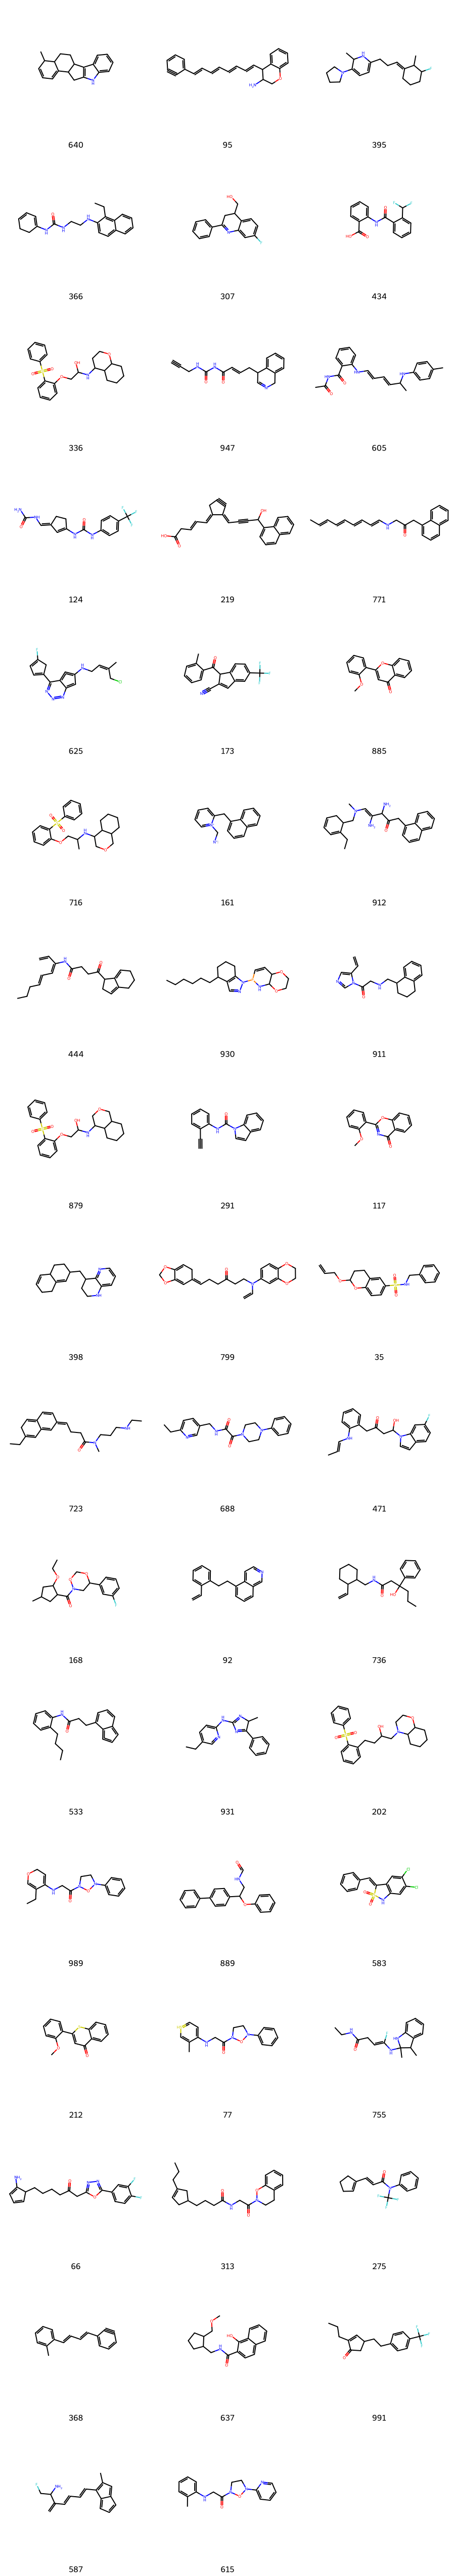

In [12]:
Draw.MolsToGridImage(top_100['mol'].tolist(), subImgSize=(300, 300), legends=[str(x) for x in top_100['index']])